# California House Prices Prediction v3 (H2O AutoML)

**Kaggle Competition**: [California House Prices](https://www.kaggle.com/competitions/california-house-prices/overview)

이 노트북에서는 **H2O AutoML**을 활용하여 캘리포니아 주택 가격을 예측합니다.

## H2O AutoML 특징
- 자동으로 여러 알고리즘 학습 (GBM, XGBoost, DRF, GLM, Deep Learning 등)
- 자동 Stacked Ensemble 생성
- 하이퍼파라미터 자동 튜닝
- Leaderboard로 모델 성능 비교

## 목차
1. H2O 설치 및 초기화
2. 데이터 로드 및 전처리
3. 특성 엔지니어링
4. H2O AutoML 학습
5. 모델 해석 및 Leaderboard
6. 예측 및 제출 파일 생성

## 1. H2O 설치 및 초기화

In [ ]:
# H2O 설치 (필요시)
# !pip install h2o

In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# H2O
import h2o
from h2o.automl import H2OAutoML

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# 재현성
SEED = 42
np.random.seed(SEED)

print('Libraries loaded successfully!')

Libraries loaded successfully!


In [16]:
# H2O 클러스터 초기화
h2o.init(
    max_mem_size='64G',  # 메모리 설정 (환경에 맞게 조절)
    nthreads=-1         # 모든 CPU 코어 사용
)

print('H2O Cluster initialized!')
h2o.cluster().show_status()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 mins 36 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,2 months and 2 days
H2O_cluster_name:,H2O_from_python_park0_v3vj2m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,27.84 Gb
H2O_cluster_total_cores:,32
H2O_cluster_allowed_cores:,32
H2O_cluster_status:,"locked, healthy"


H2O Cluster initialized!


H2O_cluster_uptime:,3 mins 36 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,2 months and 2 days
H2O_cluster_name:,H2O_from_python_park0_v3vj2m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,27.84 Gb
H2O_cluster_total_cores:,32
H2O_cluster_allowed_cores:,32
H2O_cluster_status:,"locked, healthy"


## 2. 데이터 로드 및 전처리

In [4]:
# Pandas로 데이터 로드 (전처리를 위해)
DATA_PATH = 'data/california-house-prices/'

train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (47439, 41)
Test shape: (31626, 40)


In [5]:
# 데이터 미리보기
train.head()

,Id,Address,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,0,540 Pine Ln,3825000.0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,...,"Garage, Garage - Attached, Covered",886486.0,12580.0,2019-10-24,4198000.0,NaN,NaN,Los Altos,94022,CA
1,1,1727 W 67th St,505000.0,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,...,"Detached Carport, Garage",505000.0,6253.0,2019-10-16,525000.0,2019-08-30,328000.0,Los Angeles,90047,CA
2,2,28093 Pine Ave,140000.0,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,0 spaces,9147.0,...,NaN,49627.0,468.0,2019-08-25,180000.0,NaN,NaN,Strawberry,95375,CA
3,3,10750 Braddock Dr,1775000.0,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,1947.0,Central,Central Air,"Detached Carport, Driveway, Garage - Two Door",NaN,...,"Detached Carport, Driveway, Garage - Two Door",1775000.0,20787.0,2019-10-24,1895000.0,2016-08-30,1500000.0,Culver City,90230,CA
4,4,7415 O Donovan Rd,1175000.0,Beautiful 200 acre ranch land with several pas...,VacantLand,NaN,NaN,NaN,0 spaces,NaN,...,NaN,NaN,NaN,2019-06-07,1595000.0,2016-06-27,900000.0,Creston,93432,CA


In [6]:
# Id 보관
train_id = train['Id'].copy()
test_id = test['Id'].copy()

# 불필요한 컬럼 제거
drop_cols = ['Id', 'Address', 'Summary', 'State']

for col in drop_cols:
    if col in train.columns:
        train = train.drop(col, axis=1)
    if col in test.columns:
        test = test.drop(col, axis=1)

print(f'Train shape after drop: {train.shape}')
print(f'Test shape after drop: {test.shape}')

Train shape after drop: (47439, 37)
Test shape after drop: (31626, 36)


In [7]:
# 수치형 변환
numeric_should_be = ['Year built', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
                     'Total interior livable area', 'Total spaces', 'Garage spaces',
                     'Elementary School Score', 'Elementary School Distance',
                     'Middle School Score', 'Middle School Distance',
                     'High School Score', 'High School Distance',
                     'Tax assessed value', 'Annual tax amount', 
                     'Listed Price', 'Last Sold Price']

for col in numeric_should_be:
    if col in train.columns:
        train[col] = pd.to_numeric(train[col], errors='coerce')
    if col in test.columns:
        test[col] = pd.to_numeric(test[col], errors='coerce')

print('수치형 변환 완료')

수치형 변환 완료


## 3. 특성 엔지니어링

In [8]:
def feature_engineering(df):
    """
    특성 엔지니어링 함수
    Train과 Test 데이터에 동일하게 적용
    """
    df = df.copy()
    
    # 날짜 특성 추출
    date_cols = ['Listed On', 'Last Sold On']
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            df[f'{col}_Year'] = df[col].dt.year
            df[f'{col}_Month'] = df[col].dt.month
            df[f'{col}_Quarter'] = df[col].dt.quarter
            df = df.drop(col, axis=1)
    
    # 건물 나이
    current_year = 2020
    if 'Year built' in df.columns:
        df['Building_Age'] = current_year - df['Year built']
        df['Building_Age'] = df['Building_Age'].apply(lambda x: max(0, x) if pd.notna(x) else np.nan)
    
    # 총 욕실 수
    if 'Bathrooms' in df.columns and 'Full bathrooms' in df.columns:
        df['Total_Bathrooms'] = df['Bathrooms'].fillna(0) + df['Full bathrooms'].fillna(0)
    
    # 침실당 면적
    if 'Total interior livable area' in df.columns and 'Bedrooms' in df.columns:
        bedrooms = pd.to_numeric(df['Bedrooms'], errors='coerce').fillna(0)
        df['Area_per_Bedroom'] = df['Total interior livable area'] / (bedrooms + 1)
    
    # 욕실당 면적
    if 'Total interior livable area' in df.columns and 'Total_Bathrooms' in df.columns:
        df['Area_per_Bathroom'] = df['Total interior livable area'] / (df['Total_Bathrooms'] + 1)
    
    # 침실 대 욕실 비율
    if 'Bedrooms' in df.columns and 'Total_Bathrooms' in df.columns:
        bedrooms = pd.to_numeric(df['Bedrooms'], errors='coerce').fillna(0)
        df['Bed_Bath_Ratio'] = bedrooms / (df['Total_Bathrooms'] + 1)
    
    # 주차 공간 비율
    if 'Garage spaces' in df.columns and 'Total spaces' in df.columns:
        df['Garage_Ratio'] = df['Garage spaces'] / (df['Total spaces'] + 1)
    
    # 학교 점수 통계
    school_score_cols = ['Elementary School Score', 'Middle School Score', 'High School Score']
    existing_school_cols = [col for col in school_score_cols if col in df.columns]
    if existing_school_cols:
        df['Avg_School_Score'] = df[existing_school_cols].mean(axis=1)
        df['Max_School_Score'] = df[existing_school_cols].max(axis=1)
        df['Min_School_Score'] = df[existing_school_cols].min(axis=1)
    
    # 학교 거리 통계
    distance_cols = ['Elementary School Distance', 'Middle School Distance', 'High School Distance']
    existing_dist_cols = [col for col in distance_cols if col in df.columns]
    if existing_dist_cols:
        df['Avg_School_Distance'] = df[existing_dist_cols].mean(axis=1)
        df['Min_School_Distance'] = df[existing_dist_cols].min(axis=1)
    
    # 세금 비율
    if 'Annual tax amount' in df.columns and 'Tax assessed value' in df.columns:
        df['Tax_Rate'] = df['Annual tax amount'] / (df['Tax assessed value'] + 1)
    
    # 리스팅 가격 대비 평가가 비율
    if 'Listed Price' in df.columns and 'Tax assessed value' in df.columns:
        df['Price_to_Tax_Ratio'] = df['Listed Price'] / (df['Tax assessed value'] + 1)
    
    # 가격 상승률
    if 'Listed Price' in df.columns and 'Last Sold Price' in df.columns:
        df['Price_Appreciation'] = df['Listed Price'] / (df['Last Sold Price'] + 1)
    
    # 대지 면적 대비 건물 면적 비율
    if 'Total interior livable area' in df.columns and 'Lot' in df.columns:
        df['Building_Lot_Ratio'] = df['Total interior livable area'] / (df['Lot'] + 1)
    
    # 평방피트당 리스팅 가격
    if 'Listed Price' in df.columns and 'Total interior livable area' in df.columns:
        df['Price_per_Sqft'] = df['Listed Price'] / (df['Total interior livable area'] + 1)
    
    # 무한값 처리
    df = df.replace([np.inf, -np.inf], np.nan)
    
    return df

# 특성 엔지니어링 적용
train = feature_engineering(train)
test = feature_engineering(test)

print(f'Train shape after FE: {train.shape}')
print(f'Test shape after FE: {test.shape}')

Train shape after FE: (47439, 57)
Test shape after FE: (31626, 56)


In [9]:
# 타겟 변수 로그 변환
train['Sold Price'] = np.log1p(train['Sold Price'])

print('타겟 변수 로그 변환 완료')
print(f"Log(Sold Price) 통계:")
print(train['Sold Price'].describe())

타겟 변수 로그 변환 완료
Log(Sold Price) 통계:
count    47439.000000
mean        13.739053
std          0.796761
min         11.517923
25%         13.244583
50%         13.774690
75%         14.237506
max         18.315320
Name: Sold Price, dtype: float64


In [10]:
# 컬럼 타입 확인
print('=== Train 컬럼 타입 ===')
print(train.dtypes.value_counts())
print(f'\n총 컬럼 수: {len(train.columns)}')

=== Train 컬럼 타입 ===
float64    38
object     15
int32       3
int64       1
Name: count, dtype: int64

총 컬럼 수: 57


## 4. H2O AutoML 학습

In [17]:
# Pandas DataFrame을 H2O Frame으로 변환
h2o_train = h2o.H2OFrame(train)
h2o_test = h2o.H2OFrame(test)

print(f'H2O Train shape: {h2o_train.shape}')
print(f'H2O Test shape: {h2o_test.shape}')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
H2O Train shape: (47439, 57)
H2O Test shape: (31626, 56)


In [18]:
# 범주형 변수 지정 (H2O가 자동으로 처리하도록)
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    h2o_train[col] = h2o_train[col].asfactor()
    if col in h2o_test.columns:
        h2o_test[col] = h2o_test[col].asfactor()

print(f'범주형 변수 ({len(categorical_cols)}개): {categorical_cols}')

범주형 변수 (15개): ['Type', 'Heating', 'Cooling', 'Parking', 'Region', 'Elementary School', 'Middle School', 'High School', 'Flooring', 'Heating features', 'Cooling features', 'Appliances included', 'Laundry features', 'Parking features', 'City']


In [19]:
# 타겟 변수 및 특성 변수 정의
target = 'Sold Price'
features = [col for col in h2o_train.columns if col != target]

print(f'Target: {target}')
print(f'Features: {len(features)}개')

Target: Sold Price
Features: 56개


In [20]:
# Train/Validation 분할
train_h2o, valid_h2o = h2o_train.split_frame(ratios=[0.8], seed=SEED)

print(f'Train set: {train_h2o.shape}')
print(f'Validation set: {valid_h2o.shape}')

Train set: (37998, 57)
Validation set: (9441, 57)


In [21]:
# H2O AutoML 설정 및 학습
aml = H2OAutoML(
    max_models=20,                    # 최대 모델 수
    max_runtime_secs=3600,            # 최대 학습 시간 (1시간)
    seed=SEED,
    nfolds=5,                         # 5-Fold CV
    sort_metric='RMSE',               # 정렬 기준
    verbosity='info',
    include_algos=['GBM', 'XGBoost', 'DRF', 'GLM', 'StackedEnsemble'],  # 포함할 알고리즘
    exploitation_ratio=0.1,           # 탐색 vs 활용 비율
)

print('H2O AutoML 학습 시작...')
print('(max_models=20, max_runtime_secs=3600)')

aml.train(
    x=features,
    y=target,
    training_frame=train_h2o,
    leaderboard_frame=valid_h2o
)

print('\nH2O AutoML 학습 완료!')

H2O AutoML 학습 시작...
(max_models=20, max_runtime_secs=3600)
AutoML progress: |█
19:48:29.510: Project: AutoML_2_20260126_194829
19:48:29.510: Setting stopping tolerance adaptively based on the training frame: 0.005130026762906429
19:48:29.510: Build control seed: 42
19:48:29.510: training frame: Frame key: AutoML_2_20260126_194829_training_py_35_sid_9979    cols: 57    rows: 37998  chunks: 7    size: 10605708  checksum: 5245113275681969721
19:48:29.510: validation frame: NULL
19:48:29.510: leaderboard frame: Frame key: py_36_sid_9979    cols: 57    rows: 9441  chunks: 7    size: 5853063  checksum: -8580755183326947746
19:48:29.510: blending frame: NULL
19:48:29.510: response column: Sold Price
19:48:29.510: fold column: null
19:48:29.510: weights column: null
19:48:29.510: AutoML: XGBoost is not available; skipping it.
19:48:29.510: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]},

## 5. 모델 해석 및 Leaderboard

In [22]:
# Leaderboard 확인
lb = aml.leaderboard
print('===== H2O AutoML Leaderboard =====')
print(lb.head(20))

===== H2O AutoML Leaderboard =====
model_id                                                     rmse        mse        mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_2_20260126_194829     0.189132  0.0357709  0.0919559  0.0131287                 0.0357709
StackedEnsemble_BestOfFamily_1_AutoML_2_20260126_194829  0.190451  0.0362714  0.0945619  0.0132088                 0.0362714
GBM_2_AutoML_2_20260126_194829                           0.194938  0.0380007  0.0987667  0.0135141                 0.0380007
GBM_1_AutoML_2_20260126_194829                           0.195044  0.0380423  0.0971643  0.0134946                 0.0380423
GBM_grid_1_AutoML_2_20260126_194829_model_5              0.195242  0.0381194  0.100146   0.0135578                 0.0381194
GBM_4_AutoML_2_20260126_194829                           0.195567  0.0382466  0.0977026  0.0135641                 0.0382466
GBM_3_AutoML_2_20260126_194829                           0.195885  0.0383708  0.0955202  0

c:\Users\park0\miniconda3\envs\DS\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


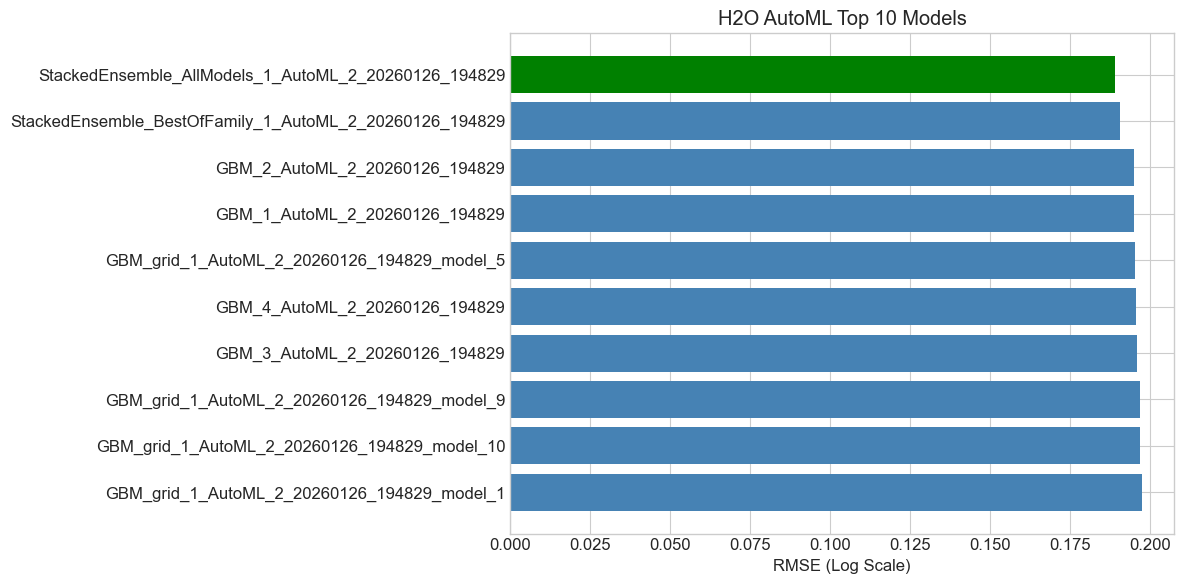

In [23]:
# Leaderboard를 Pandas DataFrame으로 변환하여 시각화
lb_df = lb.as_data_frame()

# 상위 10개 모델 시각화
plt.figure(figsize=(12, 6))
top_models = lb_df.head(10)
colors = ['green' if i == 0 else 'steelblue' for i in range(len(top_models))]
plt.barh(range(len(top_models)), top_models['rmse'], color=colors)
plt.yticks(range(len(top_models)), top_models['model_id'])
plt.xlabel('RMSE (Log Scale)')
plt.title('H2O AutoML Top 10 Models')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:
# Best Model 확인
best_model = aml.leader
print('===== Best Model =====')
print(f'Model ID: {best_model.model_id}')
print(f'Model Type: {best_model.algo}')

===== Best Model =====
Model ID: StackedEnsemble_AllModels_1_AutoML_2_20260126_194829
Model Type: stackedensemble


In [25]:
# Best Model 상세 정보
print('\n===== Best Model Performance =====')
perf = best_model.model_performance(valid_h2o)
print(perf)


===== Best Model Performance =====
ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.03577086489937052
RMSE: 0.18913187171751492
MAE: 0.09195585690579325
RMSLE: 0.013128693448857155
Mean Residual Deviance: 0.03577086489937052
R^2: 0.9434594483329903
Null degrees of freedom: 9440
Residual degrees of freedom: 9421
Null deviance: 5973.404392947068
Residual deviance: 337.7127355149571
AIC: -4610.000636924046


In [26]:
# Variable Importance (가능한 경우)
try:
    varimp = best_model.varimp(use_pandas=True)
    if varimp is not None and len(varimp) > 0:
        plt.figure(figsize=(12, 10))
        top_n = min(25, len(varimp))
        plt.barh(varimp['variable'][:top_n], varimp['scaled_importance'][:top_n])
        plt.xlabel('Scaled Importance')
        plt.title(f'Top {top_n} Variable Importance ({best_model.algo})')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print('Variable importance not available for this model type.')
except:
    print('Variable importance not available for Stacked Ensemble.')
    print('Checking individual model importances...')

Variable importance not available for this model type.


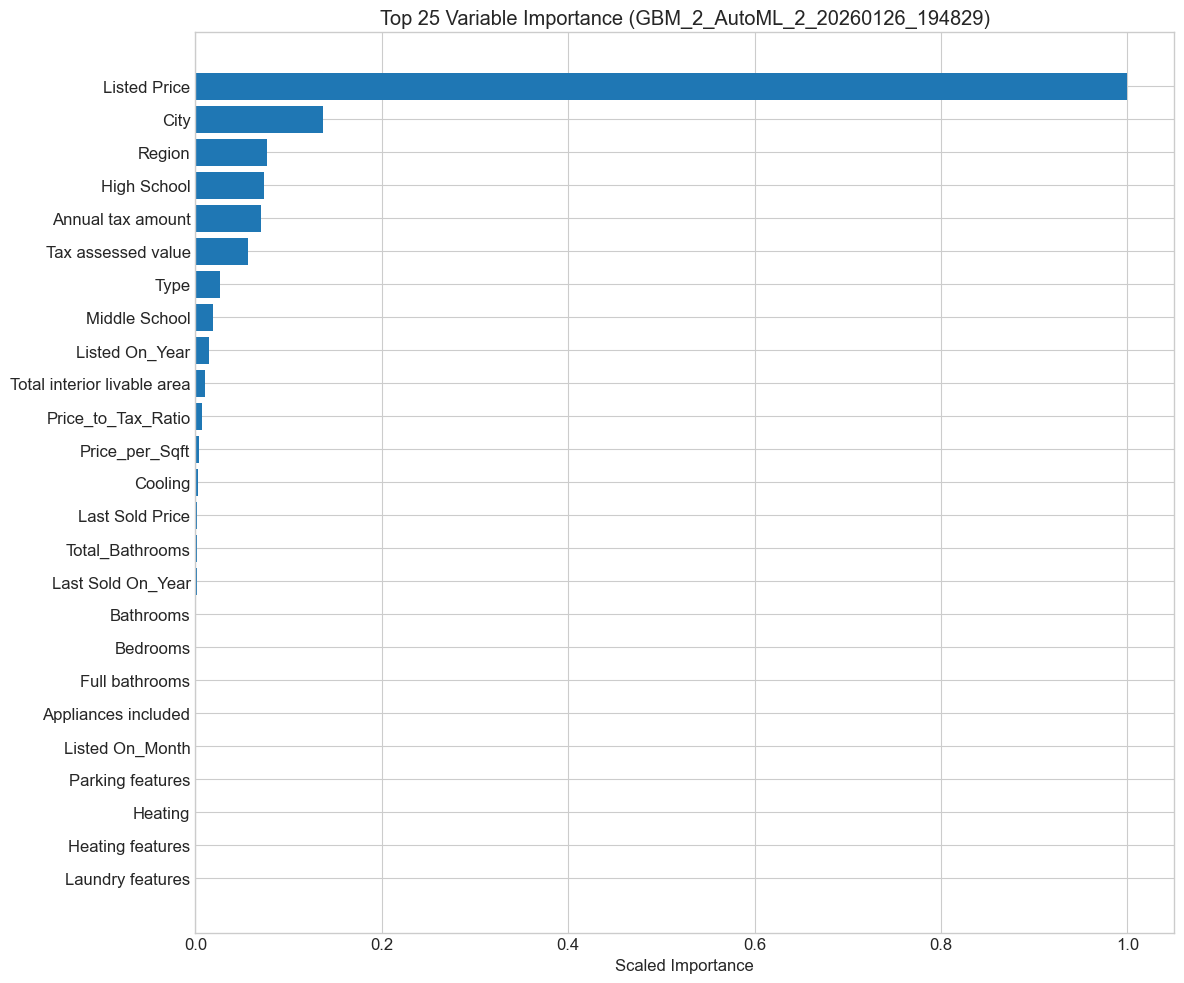

In [27]:
# GBM 또는 XGBoost 모델의 Variable Importance 확인
for model_id in lb_df['model_id'][:10]:
    if 'GBM' in model_id or 'XGBoost' in model_id:
        model = h2o.get_model(model_id)
        varimp = model.varimp(use_pandas=True)
        if varimp is not None and len(varimp) > 0:
            plt.figure(figsize=(12, 10))
            top_n = min(25, len(varimp))
            plt.barh(varimp['variable'][:top_n], varimp['scaled_importance'][:top_n])
            plt.xlabel('Scaled Importance')
            plt.title(f'Top {top_n} Variable Importance ({model_id})')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            break

In [28]:
# Validation 데이터 예측 및 평가
valid_pred = best_model.predict(valid_h2o)
valid_pred_df = valid_pred.as_data_frame()
valid_actual_df = valid_h2o[target].as_data_frame()

# RMSLE 계산 (이미 로그 변환된 상태)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

rmsle = np.sqrt(mean_squared_error(valid_actual_df, valid_pred_df))
print(f'Validation RMSLE: {rmsle:.4f}')

# 원래 스케일로 변환
valid_actual_orig = np.expm1(valid_actual_df.values.flatten())
valid_pred_orig = np.expm1(valid_pred_df.values.flatten())

rmse = np.sqrt(mean_squared_error(valid_actual_orig, valid_pred_orig))
mae = mean_absolute_error(valid_actual_orig, valid_pred_orig)
r2 = r2_score(valid_actual_orig, valid_pred_orig)

print(f'Validation RMSE: ${rmse:,.0f}')
print(f'Validation MAE: ${mae:,.0f}')
print(f'Validation R²: {r2:.4f}')

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\Users\park0\miniconda3\envs\DS\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\park0\miniconda3\envs\DS\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Validation RMSLE: 0.1891
Validation RMSE: $824,472
Validation MAE: $133,832
Validation R²: 0.7898


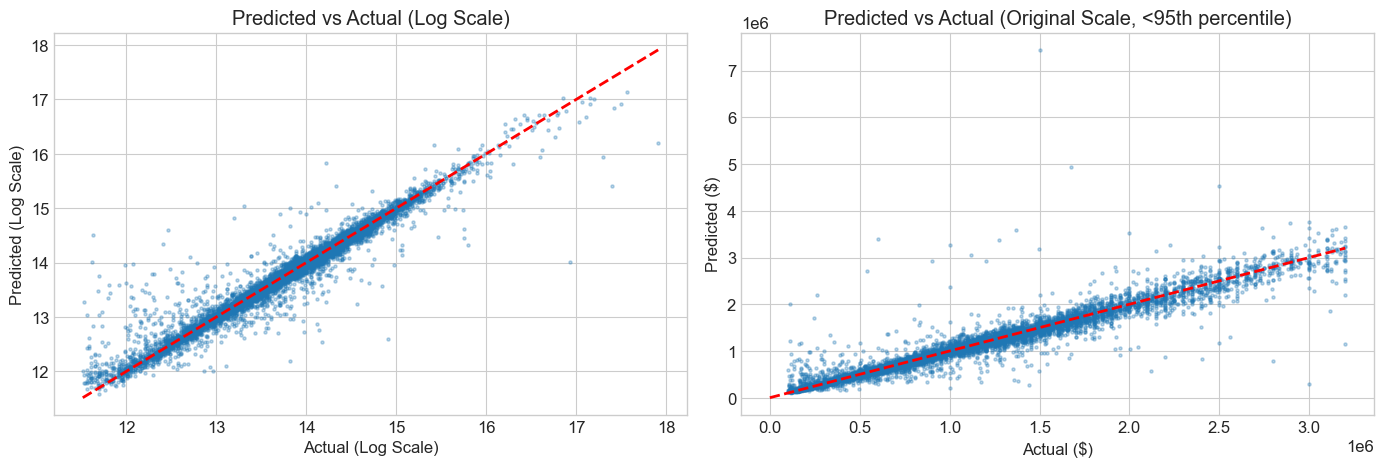

In [29]:
# 예측 vs 실제 값 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 로그 스케일
axes[0].scatter(valid_actual_df.values, valid_pred_df.values, alpha=0.3, s=5)
min_val = min(valid_actual_df.values.min(), valid_pred_df.values.min())
max_val = max(valid_actual_df.values.max(), valid_pred_df.values.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0].set_xlabel('Actual (Log Scale)')
axes[0].set_ylabel('Predicted (Log Scale)')
axes[0].set_title('Predicted vs Actual (Log Scale)')

# 원본 스케일 (상위 95% 제한)
max_price = np.percentile(valid_actual_orig, 95)
mask = valid_actual_orig <= max_price
axes[1].scatter(valid_actual_orig[mask], valid_pred_orig[mask], alpha=0.3, s=5)
axes[1].plot([0, max_price], [0, max_price], 'r--', lw=2)
axes[1].set_xlabel('Actual ($)')
axes[1].set_ylabel('Predicted ($)')
axes[1].set_title('Predicted vs Actual (Original Scale, <95th percentile)')

plt.tight_layout()
plt.show()

## 6. 예측 및 제출 파일 생성

In [30]:
# 전체 Train 데이터로 재학습 (옵션)
# 더 좋은 성능을 위해 전체 데이터로 재학습

print('전체 Train 데이터로 AutoML 재학습...')

aml_final = H2OAutoML(
    max_models=20,
    max_runtime_secs=3600,
    seed=SEED,
    nfolds=5,
    sort_metric='RMSE',
    verbosity='info',
    include_algos=['GBM', 'XGBoost', 'DRF', 'GLM', 'StackedEnsemble'],
)

aml_final.train(
    x=features,
    y=target,
    training_frame=h2o_train  # 전체 데이터 사용
)

print('\n재학습 완료!')
print(f'Best Model: {aml_final.leader.model_id}')

전체 Train 데이터로 AutoML 재학습...
AutoML progress: |█
08:52:07.364: Project: AutoML_3_20260127_85207
08:52:07.364: Setting stopping tolerance adaptively based on the training frame: 0.004591263699092305
08:52:07.364: Build control seed: 42
08:52:07.364: training frame: Frame key: AutoML_3_20260127_85207_training_py_33_sid_9979    cols: 57    rows: 47439  chunks: 7    size: 12194022  checksum: 6795104547021791696
08:52:07.364: validation frame: NULL
08:52:07.364: leaderboard frame: NULL
08:52:07.364: blending frame: NULL
08:52:07.364: response column: Sold Price
08:52:07.364: fold column: null
08:52:07.364: weights column: null
08:52:07.364: AutoML: XGBoost is not available; skipping it.
08:52:07.364: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid

H2OJobCancelled: Job<$03017f00000132d4ffffffff$_befcd0f03a46fc39d3458e72d4dd4e30> was cancelled by the user.

In [ ]:
# Test 데이터 예측
test_pred = aml_final.leader.predict(h2o_test)
test_pred_df = test_pred.as_data_frame()

# 로그 역변환
final_predictions = np.expm1(test_pred_df['predict'].values)

# 음수 값 처리
final_predictions = np.maximum(final_predictions, 0)

print(f'Final predictions shape: {final_predictions.shape}')
print(f'Min: ${final_predictions.min():,.0f}')
print(f'Max: ${final_predictions.max():,.0f}')
print(f'Mean: ${final_predictions.mean():,.0f}')
print(f'Median: ${np.median(final_predictions):,.0f}')

In [ ]:
# 제출 파일 생성
submission_df = pd.DataFrame({
    'Id': test_id.astype(int),
    'Sold Price': final_predictions
})

# 저장
submission_df.to_csv('submission_v3_h2o_automl.csv', index=False)

print('제출 파일 생성 완료!')
print(submission_df.head(10))

In [ ]:
# 예측값 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train vs Prediction 분포
train_orig = np.expm1(train['Sold Price'])
axes[0].hist(train_orig, bins=50, alpha=0.5, label='Train (Actual)', density=True)
axes[0].hist(final_predictions, bins=50, alpha=0.5, label='Test (Predicted)', density=True)
axes[0].set_xlabel('Sold Price')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution: Train Actual vs Test Predicted')
axes[0].legend()

# Log scale
axes[1].hist(train['Sold Price'], bins=50, alpha=0.5, label='Train (Actual)', density=True)
axes[1].hist(test_pred_df['predict'], bins=50, alpha=0.5, label='Test (Predicted)', density=True)
axes[1].set_xlabel('Log(Sold Price + 1)')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution (Log Scale): Train Actual vs Test Predicted')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# 모델 저장 (옵션)
# model_path = h2o.save_model(model=aml_final.leader, path='models/', force=True)
# print(f'Model saved to: {model_path}')

In [ ]:
# H2O 클러스터 종료
# h2o.cluster().shutdown()
print('노트북 실행 완료!')

## Summary

### H2O AutoML v3 특징

1. **H2O AutoML**
   - 자동으로 여러 알고리즘 학습 (GBM, XGBoost, DRF, GLM)
   - Stacked Ensemble 자동 생성
   - 5-Fold Cross Validation

2. **학습 알고리즘**
   - GBM (Gradient Boosting Machine)
   - XGBoost
   - DRF (Distributed Random Forest)
   - GLM (Generalized Linear Model)
   - StackedEnsemble (앙상블)

3. **자동화 기능**
   - 하이퍼파라미터 튜닝
   - 범주형 변수 자동 처리
   - 결측치 자동 처리
   - 모델 성능 비교 (Leaderboard)

4. **출력 파일**
   - `submission_v3_h2o_automl.csv`

### 버전 비교

| 버전 | 방법 | 특징 |
|------|------|------|
| v1 | XGB + LGB 앙상블 | 수동 하이퍼파라미터 설정 |
| v2 | Optuna + LightGBM | 자동 하이퍼파라미터 튜닝 |
| **v3** | **H2O AutoML** | **완전 자동화, 다중 알고리즘, Stacked Ensemble** |